In [1]:
# 📦 Step 1: Import Required Libraries
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')



In [2]:
# 🗃️ Step 2: Load the Dataset
df = pd.read_csv("online_retail.csv", encoding='ISO-8859-1')

df = df.dropna(subset=['Customer ID'])



In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15Cm Christmas Glass Ball 20 Lights,12,01-12-2009 07:45,6.95,13085,United Kingdom
1,489434,79323P,Pink Cherry Lights,12,01-12-2009 07:45,6.75,13085,United Kingdom
2,489434,79323W,White Cherry Lights,12,01-12-2009 07:45,6.75,13085,United Kingdom
3,489434,22041,Record Frame 7 Single Size,48,01-12-2009 07:45,2.10,13085,United Kingdom
4,489434,21232,Strawberry Ceramic Trinket Box,24,01-12-2009 07:45,1.25,13085,United Kingdom


In [4]:
# 🧹 Step 3: Preprocessing
df['CustomerID'] = df['Customer ID'].astype(str)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce', dayfirst=True)
df['TotalPrice'] = df['Quantity'] * df['Price']
df['IsCancelled'] = df['Invoice'].astype(str).str.startswith('C').astype(int)



In [5]:
# 📅 Step 4: Set Reference Date
snapshot_date = df['InvoiceDate'].max() + timedelta(days=1)



In [6]:
# 🎯 Step 5: Group and Feature Extraction
customer_gp = df.groupby('CustomerID')

features = pd.DataFrame()
features['Recency'] = customer_gp['InvoiceDate'].max().apply(lambda x: (snapshot_date - x).days)
features['FirstPurchaseDaysAgo'] = customer_gp['InvoiceDate'].min().apply(lambda x: (snapshot_date - x).days)
features['Frequency'] = customer_gp['Invoice'].nunique()
features['TotalQuantity'] = customer_gp['Quantity'].sum()
features['Monetary'] = customer_gp['TotalPrice'].sum()
features['AvgOrderValue'] = features['Monetary'] / features['Frequency']

# 🧾 Return related
features['TotalReturns'] = customer_gp['IsCancelled'].sum()
features['ReturnRate'] = features['TotalReturns'] / features['Frequency']

# 🧮 Quantity & Price Stats
features['AvgQuantityPerInvoice'] = customer_gp['Quantity'].mean()
features['MaxQuantity'] = customer_gp['Quantity'].max()
features['MinQuantity'] = customer_gp['Quantity'].min()
features['StdQuantity'] = customer_gp['Quantity'].std()

features['MeanPrice'] = customer_gp['Price'].mean()
features['MaxPrice'] = customer_gp['Price'].max()
features['MinPrice'] = customer_gp['Price'].min()
features['StdPrice'] = customer_gp['Price'].std()

# 🕒 Time Features
df['Hour'] = df['InvoiceDate'].dt.hour
df['Weekday'] = df['InvoiceDate'].dt.dayofweek
features['MostCommonHour'] = customer_gp['Hour'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
features['MostCommonWeekday'] = customer_gp['Weekday'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

# 🕐 Days Between Orders
def avg_days_between(dates):
    dates = sorted(dates)
    if len(dates) < 2:
        return np.nan
    diffs = np.diff(dates)
    return np.mean(diffs).days

features['AvgDaysBetweenOrders'] = customer_gp['InvoiceDate'].agg(lambda x: avg_days_between(x.tolist()))

# 🌍 Country (optional)
# features['Country'] = customer_gp['Country'].first()  # uncomment for label encoding later





In [13]:
from sklearn.preprocessing import StandardScaler
import joblib
import numpy as np
import pandas as pd

# Assume 'features' already has 'CustomerID' column retained
# If 'CustomerID' is in index, reset it
if features.index.name == "CustomerID" or features.index.name is not None:
    features.reset_index(inplace=True)

# Fill Missing
features.fillna(0, inplace=True)

# Normalize all columns *except* CustomerID
non_id_cols = features.columns.drop("CustomerID")
scaler = StandardScaler()
scaled_array = scaler.fit_transform(features[non_id_cols])

# Combine back into DataFrame
scaled_features = pd.DataFrame(scaled_array, columns=non_id_cols)
scaled_features["CustomerID"] = features["CustomerID"]

# Save in multiple formats
scaled_features.to_parquet("full_customer_features.parquet", index=False)
joblib.dump(scaled_features, "full_customer_features.pkl")
np.savez_compressed("full_customer_features.npz", data=scaled_array)

print(" Saved features in multiple formats:")
print(" - full_customer_features.parquet")
print(" - full_customer_features.pkl")
print(" - full_customer_features.npz")

# Preview
scaled_features.head()


 Saved features in multiple formats:
 - full_customer_features.parquet
 - full_customer_features.pkl
 - full_customer_features.npz


,Recency,FirstPurchaseDaysAgo,Frequency,TotalQuantity,Monetary,AvgOrderValue,TotalReturns,ReturnRate,AvgQuantityPerInvoice,MaxQuantity,MinQuantity,StdQuantity,MeanPrice,MaxPrice,MinPrice,StdPrice,MostCommonHour,MostCommonWeekday,AvgDaysBetweenOrders,CustomerID
0,0.595584,1.126453,0.438998,8.168099,5.166378,5.005717,0.0,0.0,5.915978,49.887133,-0.103968,19.928639,-0.014072,-0.098440,-0.022933,-0.077289,0.187925,-1.370474,0.415278,12346
1,-0.952279,-0.316980,0.131502,0.132759,0.136127,0.189436,0.0,0.0,-0.032748,0.079053,-0.083459,-0.015794,-0.034503,-0.081082,-0.027273,-0.069616,0.631193,-0.836032,-0.219649,12347
2,-0.603532,-0.164568,-0.099120,0.104253,-0.064857,0.015401,0.0,0.0,0.076422,0.014415,-0.103968,0.033421,-0.027196,0.008847,-0.027041,0.116943,0.631193,-1.370474,0.126675,12348
3,-0.871064,0.512322,-0.175994,-0.018556,0.101996,0.594632,0.0,0.0,-0.043939,-0.050223,-0.103968,-0.030806,-0.000688,0.866882,-0.026289,0.605748,-1.585148,0.232852,-0.104207,12349
4,0.519146,-0.738354,-0.406616,-0.179335,-0.181549,-0.041823,0.0,0.0,-0.037616,-0.066382,-0.103968,-0.036181,-0.026885,0.008847,-0.023801,0.087294,1.517730,-0.301590,-0.277369,12350


sanity-checking ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... 

In [14]:
print("Shape:", scaled_features.shape)
print("Missing values:\n", scaled_features.isnull().sum())
scaled_features.describe()


Shape: (5878, 20)
Missing values:
 Recency                  0
FirstPurchaseDaysAgo     0
Frequency                0
TotalQuantity            0
Monetary                 0
AvgOrderValue            0
TotalReturns             0
ReturnRate               0
AvgQuantityPerInvoice    0
MaxQuantity              0
MinQuantity              0
StdQuantity              0
MeanPrice                0
MaxPrice                 0
MinPrice                 0
StdPrice                 0
MostCommonHour           0
MostCommonWeekday        0
AvgDaysBetweenOrders     0
CustomerID               0
dtype: int64


,Recency,FirstPurchaseDaysAgo,Frequency,TotalQuantity,Monetary,AvgOrderValue,TotalReturns,ReturnRate,AvgQuantityPerInvoice,MaxQuantity,MinQuantity,StdQuantity,MeanPrice,MaxPrice,MinPrice,StdPrice,MostCommonHour,MostCommonWeekday,AvgDaysBetweenOrders
count,5.878000e+03,5.878000e+03,5.878000e+03,5.878000e+03,5.878000e+03,5.878000e+03,5878.0,5878.0,5.878000e+03,5.878000e+03,5.878000e+03,5.878000e+03,5.878000e+03,5.878000e+03,5.878000e+03,5878.000000,5.878000e+03,5.878000e+03,5.878000e+03
mean,-4.230860e-17,-3.989097e-17,-1.329699e-17,-2.417634e-18,1.208817e-17,-3.022043e-17,0.0,0.0,1.208817e-17,6.044086e-19,-4.230860e-18,-3.626452e-18,-4.230860e-18,-1.571462e-17,3.022043e-18,0.000000,2.030813e-16,5.077032e-17,9.670537e-18
std,1.000085e+00,1.000085e+00,1.000085e+00,1.000085e+00,1.000085e+00,1.000085e+00,0.0,0.0,1.000085e+00,1.000085e+00,1.000085e+00,1.000085e+00,1.000085e+00,1.000085e+00,1.000085e+00,1.000085,1.000085e+00,1.000085e+00,1.000085e+00
min,-9.570564e-01,-2.123512e+00,-4.066161e-01,-2.014182e-01,-2.045035e-01,-3.148049e-01,0.0,0.0,-6.662167e-02,-8.186840e-02,-1.039679e-01,-4.299968e-02,-4.781380e-02,-1.225975e-01,-2.871357e-02,-0.118880,-2.471684e+00,-1.370474e+00,-2.773694e-01
25%,-8.376226e-01,-7.249063e-01,-4.066161e-01,-1.804617e-01,-1.810036e-01,-1.717190e-01,0.0,0.0,-5.388413e-02,-6.638228e-02,-1.039679e-01,-3.536937e-02,-3.564723e-02,-9.510736e-02,-2.750413e-02,-0.077049,-6.986112e-01,-8.360318e-01,-2.773694e-01
50%,-5.032078e-01,2.478417e-01,-2.528681e-01,-1.474496e-01,-1.446135e-01,-8.725056e-02,0.0,0.0,-4.305202e-02,-5.022285e-02,-1.039679e-01,-3.101433e-02,-3.185924e-02,-8.108179e-02,-2.646251e-02,-0.059812,1.879252e-01,-3.015897e-01,-2.196487e-01
75%,8.535607e-01,8.664556e-01,5.462788e-02,-4.942746e-02,-4.900398e-02,2.447869e-02,0.0,0.0,-3.052086e-02,-2.867694e-02,-8.345905e-02,-2.265763e-02,-2.685972e-02,-6.722122e-02,-2.553663e-02,-0.039411,6.311934e-01,7.672944e-01,-4.648681e-02
max,2.568631e+00,1.184728e+00,3.011236e+01,4.116980e+01,4.003090e+01,6.905965e+01,0.0,0.0,7.389359e+01,5.445217e+01,2.940830e+01,7.333504e+01,6.208091e+01,3.602487e+01,6.335663e+01,54.707146,3.290803e+00,1.836179e+00,3.412413e+01


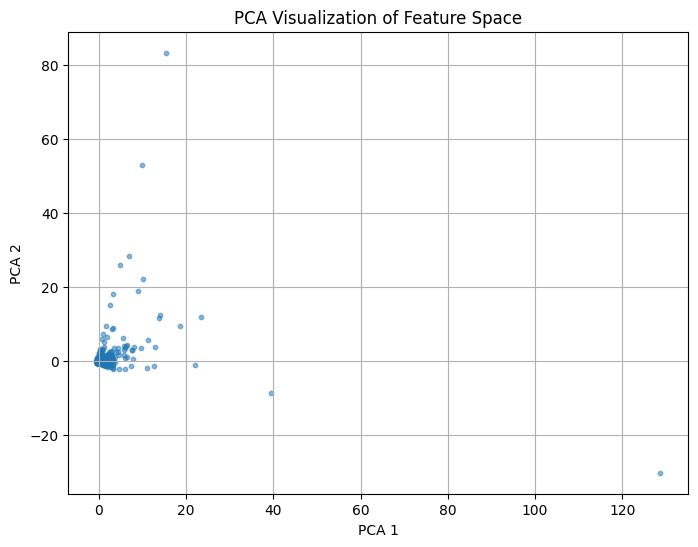

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features.drop("CustomerID", axis=1))

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5, s=10)
plt.title("PCA Visualization of Feature Space")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()


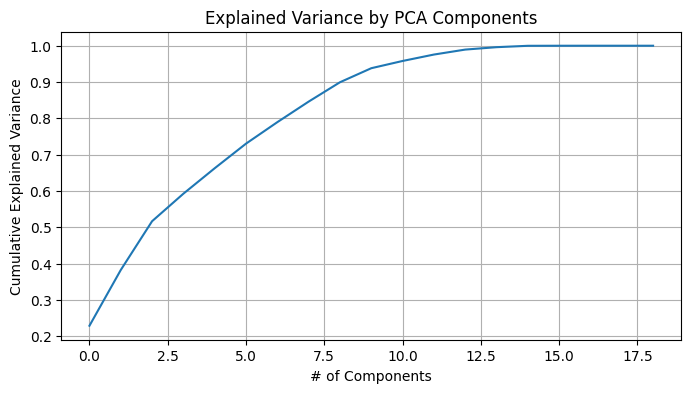

In [16]:
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(PCA().fit(scaled_features.drop("CustomerID", axis=1)).explained_variance_ratio_))
plt.title("Explained Variance by PCA Components")
plt.xlabel("# of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()


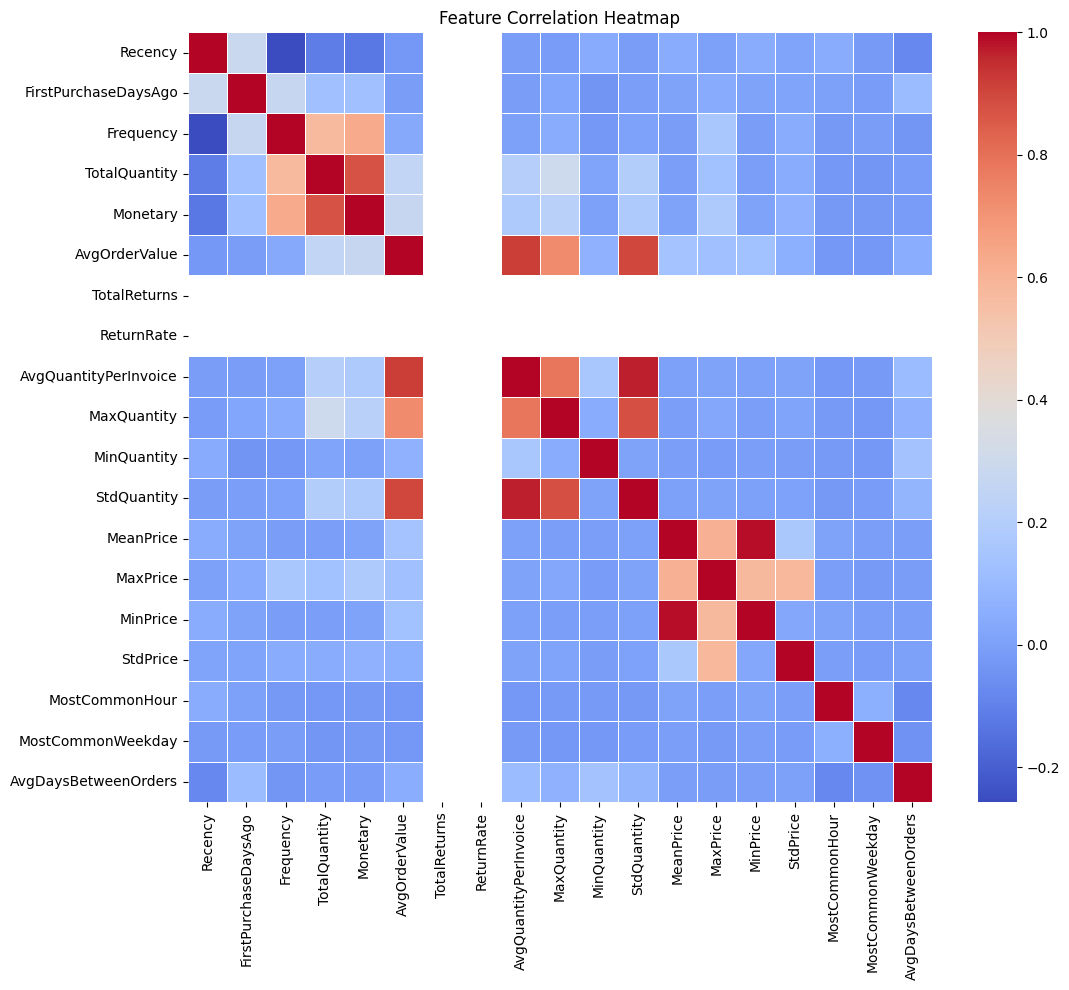

In [17]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(
    scaled_features.drop("CustomerID", axis=1).corr(),
    annot=False, cmap="coolwarm", linewidths=0.5
)
plt.title("Feature Correlation Heatmap")
plt.show()


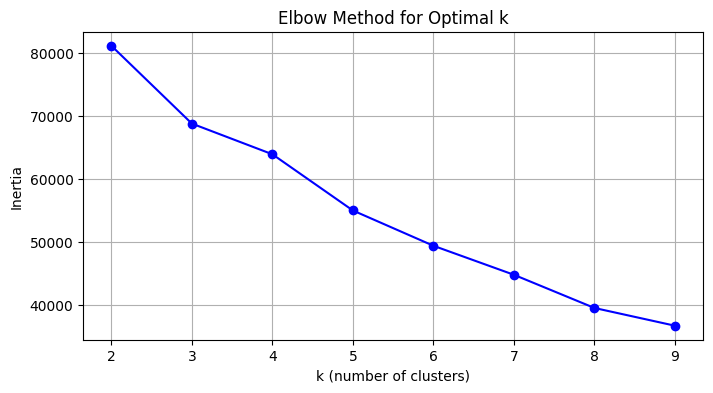

Silhouette Score (k=3): 0.9562618326873715


In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Elbow method
distortions = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(scaled_features.drop("CustomerID", axis=1))
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, distortions, 'bo-')
plt.title("Elbow Method for Optimal k")
plt.xlabel("k (number of clusters)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

# Silhouette score for best k (e.g., try k=3)
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(scaled_features.drop("CustomerID", axis=1))
print("Silhouette Score (k=3):", silhouette_score(scaled_features.drop("CustomerID", axis=1), labels))


In [19]:
import json

with open("pca_variance.json", "w") as f:
    json.dump({
        "explained_variance": list(np.cumsum(PCA().fit(scaled_features.drop("CustomerID", axis=1)).explained_variance_ratio_))
    }, f)

joblib.dump(pca_result, "pca_result.pkl")


['pca_result.pkl']